# Lecture 15

### A/B Testing, Randomized Controlled Trials, and Bootstrapping

# No class Monday

* HW05 still due Sunday
* Check Piazza for office hour updates

According to California law, the official name of the holiday is:

* A. Valentine's Day (Observed)
* B. Washington's Birthday
* C. Presidents' Day
* D. The third Monday in February

http://leginfo.legislature.ca.gov/faces/codes_displaySection.xhtml?lawCode=GOV&sectionNum=6700.

# Final A/B Testing Example: Deflategate

## Did the New England Patriots cheat?

<img height="30%" src="./deflate.jpg">

- On January 18, 2015, the Patriots played the Indianapolis Colts for a spot in the Super Bowl
- The Patriots won, 45 -- 7. They went on to win the Super Bowl
- After the game, it was alleged that the Patriots intentionally deflated footballs (making them easier to catch)

## Background

- Each team brings 12 footballs to the game.
- NFL rules stipulate: each ball must be inflated to between 12.5 and 13.5 pounds per square inch (psi).
- Before the game, officials found that all of the Patriot's balls were at about 12.5 psi, all of the Colts were about 13.0 psi.
- In the second quarter, Colts intercepted a Patriots ball and notified officials that it felt under-inflated.
- At halftime, two officials (Blakeman and Prioleau) each measured the pressure again.
- They ran out of time, and couldn't measure the pressure of all of the footballs.

## The measurements

In [1]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

In [2]:
#: all of the measurements
footballs = Table.read_table('./deflategate.csv')
footballs.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


## Combining the measurements

- Both officials measured each ball.
- Their measurements are slightly different.
- We average them to get a combined weight.

In [3]:
#: a combined measurement
footballs = footballs.with_column(
    'Combined',
    (footballs.column('Blakeman') + footballs.column('Prioleau')) / 2
)
footballs.show()

Team,Blakeman,Prioleau,Combined
Patriots,11.5,11.8,11.65
Patriots,10.85,11.2,11.025
Patriots,11.15,11.5,11.325
Patriots,10.7,11,10.85
Patriots,11.1,11.45,11.275
Patriots,11.6,11.95,11.775
Patriots,11.85,12.3,12.075
Patriots,11.1,11.55,11.325
Patriots,10.95,11.35,11.15
Patriots,10.5,10.9,10.7


## Differences in average pressure

- At first glance, it looks as though the Patriots footballs are at a lower pressure.

In [4]:
#:: group means
footballs.group('Team', np.mean)

Team,Blakeman mean,Prioleau mean,Combined mean
Colts,12.625,12.4375,12.5312
Patriots,11.1091,11.4864,11.2977


- We could do a permutation test for difference in mean pressure.
- But that wouldn't point towards cheating.
    - The Patriot's balls *started* at a lower psi.
- The allegations were that the Patriots *deflated* the balls.
    - We want to check to see if the Patriots balls lost more pressure than the Colts'.

## Calculating the pressure drop

- We therefore calculate the drop in pressure for each ball.
- Patriots' started at 12.5 psi, Colts' started at 13.
- We make an array with starting pressure for each ball.
- Handy function: `np.where(array_of_true_and_false, true_value, false_value)`.
    - Replaces `True` in the array with `true_value`, and `False` with `false_value`.

In [5]:
#...starting_pressure
starting_pressure = np.where(
    footballs.column('Team') == 'Patriots',
    12.5,
    13
)
starting_pressure

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

## Calculating the pressure drop

In [6]:
#: add the drop to the table
footballs = footballs.with_column(
    'Pressure Drop',
    starting_pressure - footballs.column('Combined')
)
footballs.show()

Team,Blakeman,Prioleau,Combined,Pressure Drop
Patriots,11.5,11.8,11.65,0.85
Patriots,10.85,11.2,11.025,1.475
Patriots,11.15,11.5,11.325,1.175
Patriots,10.7,11,10.85,1.65
Patriots,11.1,11.45,11.275,1.225
Patriots,11.6,11.95,11.775,0.725
Patriots,11.85,12.3,12.075,0.425
Patriots,11.1,11.55,11.325,1.175
Patriots,10.95,11.35,11.15,1.35
Patriots,10.5,10.9,10.7,1.8


## The question

- Did the Patriots' footballs drop in pressure more than the Colts'?
- A/B test!
- **Null hypothesis**: The drop in pressures for both teams came from the same distribution.
    - By chance, the Patriots' footballs deflated more.
- **Alternative hypothesis**: No, the Patriots' footballs deflated more than one would expect due to random chance alone.

## The statistic

- Difference between teams' average pressure drops.

In [7]:
#: the group means
means = footballs.group('Team', np.mean).select('Team', 'Pressure Drop mean')
means

Team,Pressure Drop mean
Colts,0.46875
Patriots,1.20227


In [8]:
#: the observed difference
mean_drop = means.column('Pressure Drop mean')
observed_difference = mean_drop.item(1) - mean_drop.item(0)
observed_difference

0.733522727272728

- The average pressure drop for the Patriots was 0.73 psi more than the Colts.

## Permutation test

- We run a permutation test to see if this is a significant difference.
- Permute the drop in pressure (or the team column), many times.

In [9]:
#: run a permutation test
n_repetitions = 5000

differences = make_array()
for i in np.arange(n_repetitions):
    # shuffle the weights
    shuffled_drops = (
        footballs
        .sample(with_replacement=False)
        .column('Pressure Drop')
    )
    
    # put them in a table
    shuffled = footballs.with_column(
        'Shuffled Pressure Drop', 
        shuffled_drops
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .group('Team', np.mean)
        .column('Shuffled Pressure Drop mean')
    )
    difference = group_means.item(1) - group_means.item(0)
    
    # add it to our array storing results
    differences = np.append(differences, difference)

## Conclusion

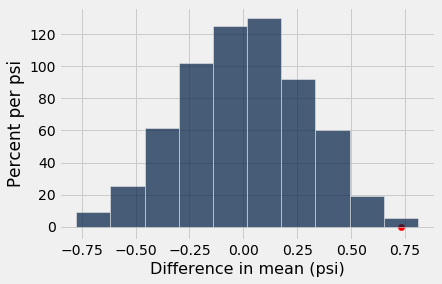

In [10]:
#:: visualize
Table().with_column('Difference in mean', differences).hist(unit='psi')
plt.scatter(observed_difference, 0, color='red', s=40)

- It doesn't look good for the Patriots. What is the p-value?

In [11]:
#: p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.0022

## Caution!

- We conclude that it is unlikely that the difference in mean pressure drop is due to chance alone.
- But this doesn't establish *causation*.
- That is, did the Patriots *deliberately* deflate their footballs?
- This was an *observational* study; to establish causation, we need an RCT (Randomized Controlled Trial).

# Causality

## Recap

- We have used A/B testing to assess group differences.
- Example:
    - Study: Babies born to mothers who smoke typically weigh less.
    - Permutation test conclusion: this is unlikely to be due to random chance.
- Rejecting the null hypothesis **does not** establish causality.
    - Tempting to think that smoking causes lower birthweight.
    - But there could be **confounding factors**...
    - Maybe *caffeine* causes lower birthweight, and caffeine intake is correlated with smoking.

## Randomized Controlled Trial

- This was an **observational study**.
- We've seen that randomizing groups then applying "treatment" avoids confounding factors.
- This is known as a **Randomized Controlled Trial** (RCT).
- An A/B test in a RCT *does* support causality.

## Why?

- Suppose we want to examine the link between chocolate and heart health.
- We do an observational study and see that chocolate-eaters have healthier hearts.

In [12]:
#: chocolate and heart health
Table.read_table('coffee_observational.csv').select('Chocolate', 'Good Heart')

Chocolate,Good Heart
1,1
1,0
1,1
1,1
1,1
0,0
0,0
0,1
0,0
0,0


- We want to say that eating chocolate *causes* good heart health.
- But it turns out that chocolate-eaters are more likely to consume caffeine.
- And suppose it is *caffeine* which actually helps heart health.

In [ ]:
#: chocolate, caffeine, and heart health
Table.read_table('coffee_observational.csv')

## Why?

- The chocolate-eating group had better health because it had more caffeine consumers.
- Now suppose we do an RCT and select random groups.
- *Then* we apply the treatment (chocolate).

In [13]:
#: the rct results
Table.read_table('coffee_rct.csv')

Caffeine,Chocolate,Good Heart
1,1,1
0,1,0
1,1,1
0,1,0
0,1,1
1,0,1
0,0,0
0,0,0
1,0,1
1,0,1


- Randomization ensures that the caffeine consumers are (roughly) divided between the treatment and control group.
- The effect of the confounding factor is mitigated.

## Example: Chronic Back Pain

## Treatment with botulinum toxin

- Botulinum Toxin A is the "most acutely lethal toxin known" (Wikipedia).
    - About 100 *nanograms* injected intravenously is lethal to a human.
- Used for treating muscle disorders and for cosmetic reasons (Botox).
- A randomized controlled study examined the use of Botulinum Toxin A in the treatment of lower back pain.
    - 31 patients with pain were randomly assigned to control and treatment groups.
    - Control group received placebo (saline).
    - Treatment group received botulinism toxin.
    - After eight weeks, the number of people who experienced relief was counted.

## The data

In [14]:
#: 1 means "experienced relief", 0 means "no relief"
back = Table.read_table('./bta.csv')
back.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


## The results

In [15]:
#:: the distribution of outcomes
back.pivot('Group', 'Result')

Result,Control,Treatment
0,14,6
1,2,9


- It looks like there was a clear benefit to treatment.
- Can this just be due to chance?

## An A/B test

- Group A = Control, Group B = Treatment
- **Null hypothesis**: Results for both groups come from the same distribution.
- **Test statistic**: difference in proportion experiencing relief.

In [16]:
#: proportion experiencing relief
relief = back.group('Group', np.mean)
relief

Group,Result mean
Control,0.125
Treatment,0.6


In [17]:
#: the observed group difference
reliefs = relief.column('Result mean')
observed_difference = reliefs.item(1) - reliefs.item(0)
observed_difference

0.475

## The simulation

In [18]:
#: run a permutation test
n_repetitions = 500

differences = make_array()

for i in np.arange(n_repetitions):
    # permute the results
    shuffled_results = (
        back
        .sample(with_replacement=False)
        .column('Result')
    )
    
    shuffled = back.with_column('Result', shuffled_results)
    
    # compute the statistic
    relief = shuffled.group('Group', np.mean).column('Result mean')
    difference = relief.item(1) - relief.item(0)
    differences = np.append(differences, difference)

## Conclusion

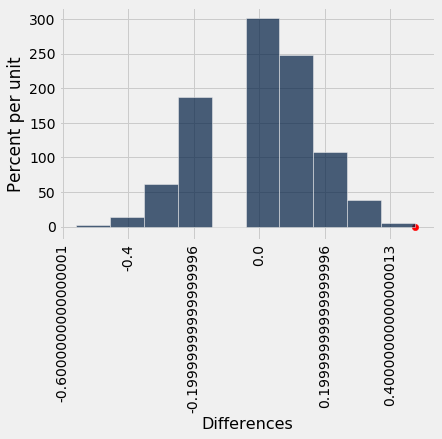

In [19]:
#: draw a histogram
Table().with_column('Differences', differences).hist()
plt.scatter(observed_difference, 0, color='red', s=40)

In [20]:
#: compute a p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

0.006

## Conclusion

- We reject the null hypothesis with a high degree of confidence.
- This is evidence that the treatment *caused* improvement.
    - *Because* this was an *randomized controlled trial*.

# Bootstrap Method

## Question

- What is the median salary of San Diego city employees?
- All city employee salary data is public.

In [21]:
#: read in the data
population = Table.read_table('salaries.csv')
population

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Notes,Agency,Status
David P Gerboth,Fire Battalion Chief,81917,172590,68870,5194,323377,328571,2017,nan,San Diego,FT
Glen A Bartolome,Fire Captain,85904,120682,99408,10107,305994,316101,2017,nan,San Diego,FT
Scott C Chadwick,Chief Operating Officer,255000,0,31164,22688,286164,308852,2017,nan,San Diego,FT
David W Pilkerton,Fire Battalion Chief,100110,118798,62895,18746,281803,300549,2017,nan,San Diego,FT
Daniel S Reeves,Fire Captain,41389,196284,42027,20125,279700,299825,2017,nan,San Diego,PT
Edward S Jones,Fire Captain,46020,171896,59944,19669,277860,297529,2017,nan,San Diego,PT
Richard L Ballard,Fire Battalion Chief,99629,93528,61055,16630,254212,270842,2017,nan,San Diego,FT
Mark A Hovey,Retirement Administrator,240000,0,6190,21909,246190,268099,2017,nan,San Diego,FT
Adrian A Blackson,Fire Captain,44280,196978,16933,8304,258191,266495,2017,nan,San Diego,PT
Stacey D Lomedico,Asst Chief Oper Ofcr,215000,0,20352,30087,235352,265439,2017,nan,San Diego,FT


## The median salary

- We can use `np.median()`:

In [22]:
#...population_median
# the median of the "Total Pay" column
population_median = np.median(population.column('Total Pay'))
population_median

66665.5

## But now...

- ...suppose we don't have access to this data.
- It is costly and time-consuming to survey *all* 11,000+ employees.
- So we gather salaries for a random sample of, say, 500 people.
- Hope the median of the sample $\approx$ median of the population.

## In the language of statistics...

- The full table of salaries is the **population**.
- We observe a **sample** of 500 salaries from the population.
- We really want the population median, but we don't have the whole population.
- So we compute sample median as an **estimate**.
- Hopefully the sample median is close to the population median.

## The sample median

- Let's survey 500 employees at random.
- We can use `.sample()`:

In [29]:
#: take a sample of size 500
sample = population.sample(500, with_replacement=False)

In [30]:
#: compute the sample median
sample_median = np.median(sample.column('Total Pay'))
sample_median

63990.0

## How confident are we?

- Our estimate depended on a random sample.
- If our sample was different, our estimate would've been different, too.
- **How different could the estimate have been?**
- Our confidence in the estimate depends on the answer.

## The sample median is random

- The sample median is a random number.
- It comes from some distribution, which we don't know.
- How different could the estimate have been?
    - "Narrow" distribution $\Rightarrow$ not too different
    - "Wide" distribution $\Rightarrow$ quite different
- **What is the distribution of the sample median?**

## A (costly) approach

- Every sample of 500 people gives me one observation of the sample median.
- So draw a bunch of samples, compute medians.

In [31]:
#: imports for animation
from lecture import sampling_animation
from IPython.display import HTML

In [32]:
%%capture
anim, sample_medians = sampling_animation(population)

In [33]:
#: display animation
HTML(anim.to_jshtml())

## Visualize the distribution

- We can plot the distribution of the sample median with a histogram.
- This is an approximation using 128 samples.
- Sample median is usually in [62,000, 70,000].

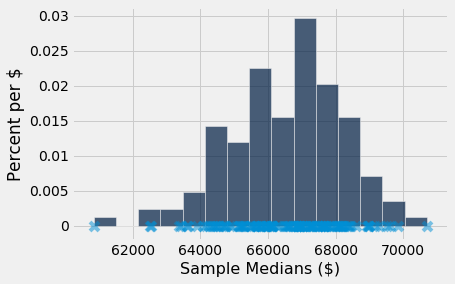

In [34]:
#: plot a histogram
Table().with_column('Sample Medians', sample_medians).hist(bins=15, unit='$')

# show each sample median as an 'x'
plt.scatter(sample_medians, np.zeros_like(sample_medians), marker='x', s=80, alpha=.5).set_zorder(2)

## The problem

- Drawing new samples like this is costly (why not just do a census?)
- Often, we can't ask for new samples from the population.
- The bootstrap:
    - the sample itself looks like the distribution.
    - so re-sampling from the sample is like drawing from the distribution.

In [35]:
#: a trick to plot the sample and the distribution side-by-side
bins=np.arange(10_000, 300_000, 10_000)
labels = ['Population']*population.num_rows + ['Sample']*sample.num_rows
together = population.append(sample).with_column('Labels', labels)

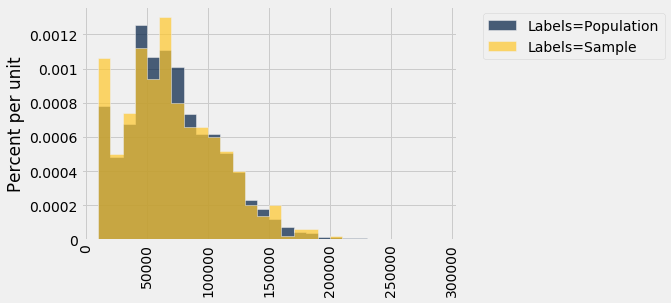

In [36]:
#: plot
together.hist('Total Pay', group='Labels', bins=bins)

## The bootstrap

- We have a sample of 500 salaries, we want another.
- Can't draw from the population.
- But the original sample looks like the population.
- So we re-sample the sample.

## Discussion question

Which of these effectively resamples the sample, simulating the drawing of a new sample of 500 people?

- A) `np.random.choice(sample, 500, replace=True)`
- B) `np.random.choice(sample, 500, replace=False)`
- C) `sample.sample(with_replacement=True)`
- D) `sample.sample(with_replacement=False)`

## Answer

- If we sample without replacement, we're just shuffling.
- So we sample *with* replacement to get something new.

## Running the bootstrap

- Now we can simulate new samples by bootstrapping
- I.e., we sample with replacement from our original sample

In [39]:
n_resamples = 5000

boot_medians = make_array()
for i in range(n_resamples):
    # perform bootstrap resampling
    resample = sample.sample(500, with_replacement=True)
    
    # compute the median
    median = np.median(resample.column('Total Pay'))
    
    # tack it on to our list of medians
    boot_medians = np.append(boot_medians, median)

## Bootstrap distribution of the sample median

- Bulk of the time, the sample median is typically in [60,000, 70,000].
- Similar to what we found before.
- The population median (red dot) is near the middle.

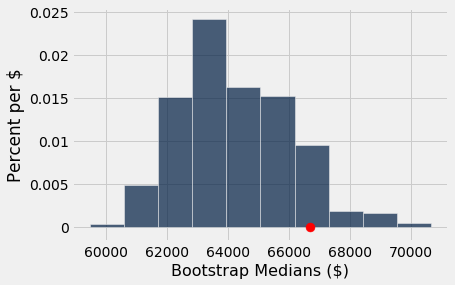

In [41]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist(unit='$')
plt.scatter(population_median, 0, color='red', s=80).set_zorder(2)

## Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We used just one sample to get the (approximate) distribution of the sample median.
- But it has limitations:
    - Not good for sensitive statistics, like maximum.
    - Requires sample to be good approximation of population.
    - Works best when population is roughly bell-shaped.
    - Can be slow (recommend 10,000+ bootstrap samples)